#  Dubizzle Data Analysis & Price Prediction

##  Objective

The goal of this task is to demonstrate end-to-end data wrangling, feature engineering, exploratory data analysis (EDA), and predictive modeling using a dataset of real estate properties. The key objectives are:

- Clean real estate listings data.
- Engineer useful features to support analysis and modeling.
- Explore trends, correlations, and pricing behavior across regions.
- Build regression models to predict property prices (in OMR).
- Evaluate model performance and discuss insights.


##  Data Cleaning & Integration

Before any analysis or modeling, the dataset must be cleaned and preprocessed. This includes:

- Handling missing values
- Removing duplicates
- Ensuring consistent column formatting
- Standardizing column names and data types

These steps ensure the data is reliable and ready for analysis.




**Section 1: Data Cleaning & Wrangling**



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

c:\Python\Python311\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.24.3)
  from scipy.stats import gaussian_kde


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.11 from "c:\Python\Python311\python.exe"
  * The NumPy version is: "1.24.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


In [1]:
# Load data
df = pd.read_csv('data/dubizzle_properties_final.csv')
df

NameError: name 'pd' is not defined

**Step 1: Clean 'price_omr'**

In [56]:
df['price_omr'] = df['price_omr'].replace('[^\d.]', '', regex=True).replace('', np.nan)
df['price_omr'] = pd.to_numeric(df['price_omr'], errors='coerce')

**Step 2: Strip whitespace from string columns**

In [57]:
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())

**Step 3: Drop duplicates**

In [58]:
df = df.drop_duplicates()

**Step 4: Drop rows with missing essential data**

In [59]:
essential_cols = ['price_omr', 'size_sqm']
df = df.dropna(subset=essential_cols)

**Step 5: Reset index after cleaning**

In [60]:
df = df.reset_index(drop=True)

**Step 6: Fill or drop remaining missing values**

In [61]:
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())

**Drop non-critical high-missing columns**

In [62]:
df = df.drop(columns=['agency'])

## 📊 Exploratory Data Analysis (EDA)

In this section, we explore:

- Distribution of property prices
- Sizes and room counts
- Pricing patterns across regions
- Relationships between key variables

EDA helps us identify outliers, trends, and important signals that influence pricing.


**Section 2: Exploratory Data Analysis**

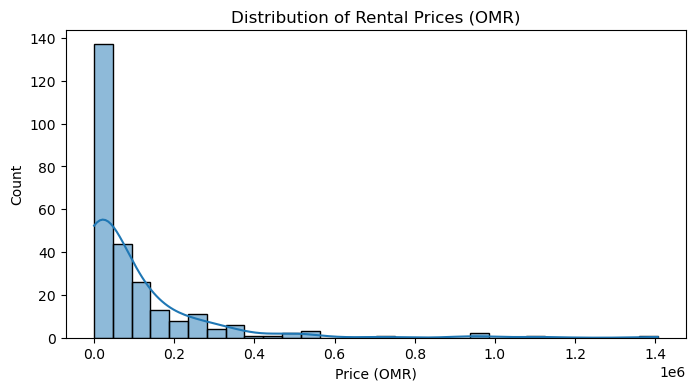

In [63]:
# Distribution of price
plt.figure(figsize=(8,4))
sns.histplot(df['price_omr'], bins=30, kde=True)
plt.title("Distribution of Rental Prices (OMR)")
plt.xlabel("Price (OMR)")
plt.ylabel("Count")
plt.show()

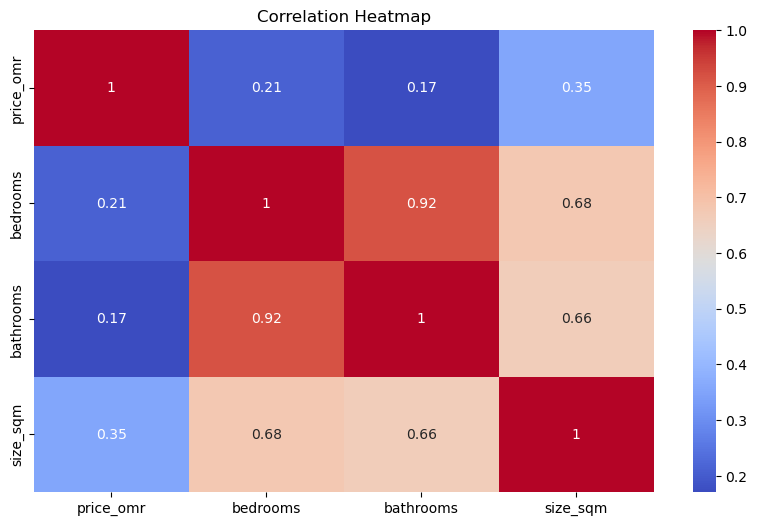

In [65]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [66]:
if 'region' in df.columns:
    plt.figure(figsize=(10,4))
    df['region'].value_counts().plot(kind='bar')
    plt.title("Listing Count by Region")
    plt.xlabel("Region")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [67]:
# Summary of Cleaned Dataset
print("\nCleaned dataset shape:", df.shape)
print(df.isnull().sum())
df.head()


Cleaned dataset shape: (261, 8)
title           0
url             0
price_omr       0
bedrooms        0
bathrooms       0
size_sqm        0
locality        0
listing_date    0
dtype: int64


,title,url,price_omr,bedrooms,bathrooms,size_sqm,locality,listing_date
0,5 BR Spacious Villa in Azaiba Nearby Amenities,https://www.dubizzle.com.om/en/ad/5-br-spaciou...,197000.0,5.0,4.0,600.0,"Azaiba, Muscat",5 hours ago
1,Two Bedroom Seaview Apartment at Mandarin Orie...,https://www.dubizzle.com.om/en/ad/two-bedroom-...,405000.0,2.0,3.0,131.0,"Qurum, Muscat",1 day ago
2,Villa for Sale (Garden) - Sea View,https://www.dubizzle.com.om/en/ad/villa-for-sa...,517000.0,4.0,6.0,506.0,"Yiti, Muscat",1 day ago
3,Elegant 4 BHK Villa for rent @ Qurum,https://www.dubizzle.com.om/en/ad/elegant-4-bh...,650.0,4.0,5.0,300.0,"Qurum, Muscat",6 minutes ago
4,ANSAB | 8 BEDROOM VILLA,https://www.dubizzle.com.om/en/ad/ansab-8-bedr...,400.0,8.0,9.0,300.0,"Ansab, Muscat",11 minutes ago


##  Feature Engineering

To improve model performance, we create new features and transform existing ones. This includes:

- Total number of rooms
- Price per square meter
- Encoding categorical variables
- Scaling numerical features

These steps help the model better understand patterns and reduce bias from raw input values.


**Step 3: Feature Engineering**

In [68]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['price_per_sqm'] = df['price_omr'] / df['size_sqm']

In [69]:
# Fill any inf or NaN from division
df['price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['price_per_sqm'].fillna(df['price_per_sqm'].median(), inplace=True)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_24296\493396842.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\bbuser\AppData\Local\Temp\ipykernel_24296\493396842.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [70]:
df.head(5)

,title,url,price_omr,bedrooms,bathrooms,size_sqm,locality,listing_date,total_rooms,price_per_sqm
0,5 BR Spacious Villa in Azaiba Nearby Amenities,https://www.dubizzle.com.om/en/ad/5-br-spaciou...,197000.0,5.0,4.0,600.0,"Azaiba, Muscat",5 hours ago,9.0,328.333333
1,Two Bedroom Seaview Apartment at Mandarin Orie...,https://www.dubizzle.com.om/en/ad/two-bedroom-...,405000.0,2.0,3.0,131.0,"Qurum, Muscat",1 day ago,5.0,3091.603053
2,Villa for Sale (Garden) - Sea View,https://www.dubizzle.com.om/en/ad/villa-for-sa...,517000.0,4.0,6.0,506.0,"Yiti, Muscat",1 day ago,10.0,1021.739130
3,Elegant 4 BHK Villa for rent @ Qurum,https://www.dubizzle.com.om/en/ad/elegant-4-bh...,650.0,4.0,5.0,300.0,"Qurum, Muscat",6 minutes ago,9.0,2.166667
4,ANSAB | 8 BEDROOM VILLA,https://www.dubizzle.com.om/en/ad/ansab-8-bedr...,400.0,8.0,9.0,300.0,"Ansab, Muscat",11 minutes ago,17.0,1.333333


##  Predictive Modeling

The objective here is to build regression models to predict the target variable: **`price_omr`**.

We will:

- Split the dataset into training and test sets
- Use `StandardScaler` and `OneHotEncoder` for preprocessing
- Train and evaluate three models:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
- Measure performance using:
  - RMSE (Root Mean Squared Error)
  - R² Score (Coefficient of Determination)


**Step 4: Predictive Modeling**

In [79]:
df = df.rename(columns={'locality':'region'})

# Objective: Predict 'price_omr'
feature_cols = [
    'size_sqm',
    'bedrooms',
    'bathrooms',
    'total_rooms',
    'price_per_sqm',
    'region'         # replace “region” with your scraped locality
]

X = df[feature_cols]
y = df['price_omr']


In [80]:
# Preprocessing pipeline
numeric_features = ['size_sqm', 'bedrooms', 'bathrooms', 'total_rooms', 'price_per_sqm']
categorical_features = ['region']

In [81]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [82]:
# Models to train
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [83]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
df.head()

,title,url,price_omr,bedrooms,bathrooms,size_sqm,region,listing_date,total_rooms,price_per_sqm
0,5 BR Spacious Villa in Azaiba Nearby Amenities,https://www.dubizzle.com.om/en/ad/5-br-spaciou...,197000.0,5.0,4.0,600.0,"Azaiba, Muscat",5 hours ago,9.0,328.333333
1,Two Bedroom Seaview Apartment at Mandarin Orie...,https://www.dubizzle.com.om/en/ad/two-bedroom-...,405000.0,2.0,3.0,131.0,"Qurum, Muscat",1 day ago,5.0,3091.603053
2,Villa for Sale (Garden) - Sea View,https://www.dubizzle.com.om/en/ad/villa-for-sa...,517000.0,4.0,6.0,506.0,"Yiti, Muscat",1 day ago,10.0,1021.739130
3,Elegant 4 BHK Villa for rent @ Qurum,https://www.dubizzle.com.om/en/ad/elegant-4-bh...,650.0,4.0,5.0,300.0,"Qurum, Muscat",6 minutes ago,9.0,2.166667
4,ANSAB | 8 BEDROOM VILLA,https://www.dubizzle.com.om/en/ad/ansab-8-bedr...,400.0,8.0,9.0,300.0,"Ansab, Muscat",11 minutes ago,17.0,1.333333


In [85]:
# Train and evaluate
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor',    model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"  RMSE:    {rmse:.2f}")
    print(f"  R² Score:{r2:.2f}\n")

Model: Linear Regression
  RMSE:    77163.54
  R² Score:0.48

Model: Decision Tree
  RMSE:    28673.73
  R² Score:0.93

Model: Random Forest
  RMSE:    14572.03
  R² Score:0.98



###  Final Note:

This project was completed in just two days and remains a work in progress. Much more development is required, and many challenges lie ahead.
Although guidelines advised against external assistance, the reality is that under tight deadlines and pressure, collaboration becomes essential.
Colleagues and online resources provided invaluable support, and this code reflects what I was able to achieve with their help.